# Identifying Friendly Squirrels #

In [1]:
from __future__ import print_function
from packaging.version import parse as Version
from platform import python_version

OK = '\x1b[42m[ OK ]\x1b[0m'
FAIL = "\x1b[41m[FAIL]\x1b[0m"

try:
    import importlib
except ImportError:
    print(FAIL, "Python version 3.12 is required,"
                " but %s is installed." % sys.version)

def import_version(pkg, min_ver, fail_msg=""):
    mod = None
    try:
        mod = importlib.import_module(pkg)
        if pkg in {'PIL'}:
            ver = mod.VERSION
        else:
            ver = mod.__version__
        if Version(ver) == Version(min_ver):
            print(OK, "%s version %s is installed."
                  % (lib, min_ver))
        else:
            print(FAIL, "%s version %s is required, but %s installed."
                  % (lib, min_ver, ver))    
    except ImportError:
        print(FAIL, '%s not installed. %s' % (pkg, fail_msg))
    return mod


# first check the python version
pyversion = Version(python_version())

if pyversion >= Version("3.12.5"):
    print(OK, "Python version is %s" % pyversion)
elif pyversion < Version("3.12.5"):
    print(FAIL, "Python version 3.12.5 is required,"
                " but %s is installed." % pyversion)
else:
    print(FAIL, "Unknown Python version: %s" % pyversion)

    
print()
requirements = {'numpy': "1.26.4", 'matplotlib': "3.9.2",'sklearn': "1.5.1", 
                'pandas': "2.2.2",'xgboost': "2.1.1", 'shap': "0.45.1", 
                'plotly': "5.23.0"}

# now the dependencies
for lib, required_version in list(requirements.items()):
    import_version(lib, required_version)

[ OK ] Python version is 3.12.5

[ OK ] numpy version 1.26.4 is installed.
[ OK ] matplotlib version 3.9.2 is installed.
[ OK ] sklearn version 1.5.1 is installed.
[ OK ] pandas version 2.2.2 is installed.
[ OK ] xgboost version 2.1.1 is installed.
[ OK ] shap version 0.45.1 is installed.
[ OK ] plotly version 5.23.0 is installed.


In [2]:
import numpy as np 
import pandas as pd
import matplotlib 
from matplotlib import pylab as plt
import os
import warnings
warnings.filterwarnings('ignore') #ignore warning messages 

In [3]:
# Load dataset
df_original = pd.read_csv('/Users/songxiaoke/Desktop/1030project_squirrels/data/central_part_squirrels_(raw).csv')
df_original.head()

,X,Y,Unique Squirrel ID,Hectare,Shift,Date,Hectare Squirrel Number,Age,Primary Fur Color,Highlight Fur Color,...,Kuks,Quaas,Moans,Tail flags,Tail twitches,Approaches,Indifferent,Runs from,Other Interactions,Lat/Long
0,-73.956134,40.794082,37F-PM-1014-03,37F,PM,10142018,3,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,NaN,POINT (-73.9561344937861 40.7940823884086)
1,-73.968857,40.783783,21B-AM-1019-04,21B,AM,10192018,4,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,NaN,POINT (-73.9688574691102 40.7837825208444)
2,-73.974281,40.775534,11B-PM-1014-08,11B,PM,10142018,8,NaN,Gray,NaN,...,False,False,False,False,False,False,False,False,NaN,POINT (-73.97428114848522 40.775533619083)
3,-73.959641,40.790313,32E-PM-1017-14,32E,PM,10172018,14,Adult,Gray,NaN,...,False,False,False,False,False,False,False,True,NaN,POINT (-73.9596413903948 40.7903128889029)
4,-73.970268,40.776213,13E-AM-1017-05,13E,AM,10172018,5,Adult,Gray,Cinnamon,...,False,False,False,False,False,False,False,False,NaN,POINT (-73.9702676472613 40.7762126854894)


# Exploratory Data Analysis #

In [4]:
print(df_original.shape)

(3023, 31)


In [5]:
df_original.describe()

,X,Y,Date,Hectare Squirrel Number
count,3023.000000,3023.000000,3.023000e+03,3023.000000
mean,-73.967184,40.780853,1.011949e+07,4.123718
std,0.007726,0.010285,4.246671e+04,3.096492
min,-73.981159,40.764911,1.006202e+07,1.000000
25%,-73.973102,40.771676,1.008202e+07,2.000000
50%,-73.968594,40.778166,1.012202e+07,3.000000
75%,-73.960189,40.791219,1.014202e+07,6.000000
max,-73.949722,40.800119,1.020202e+07,23.000000


#### Check Missing Values for Original Datasets ####

In [6]:
# Check Missing valyes for Original Datasets
perc_missing_per_ftr = df_original.isnull().sum(axis = 0)/df_original.shape[0]
print('fraction of missing values in features:')
print(perc_missing_per_ftr[perc_missing_per_ftr > 0])
print('data types of the features with missing values:')
print(df_original[perc_missing_per_ftr[perc_missing_per_ftr > 0].index].dtypes)
frac_missing = sum(df_original.isnull().sum(axis = 1)!=0)/df_original.shape[0]
print('fraction of points with missing vlaues:', frac_missing)

fraction of missing values in features:
Age                                 0.040026
Primary Fur Color                   0.018194
Highlight Fur Color                 0.359246
Color notes                         0.939795
Location                            0.021171
Above Ground Sighter Measurement    0.037711
Specific Location                   0.842541
Other Activities                    0.855442
Other Interactions                  0.920609
dtype: float64
data types of the features with missing values:
Age                                 object
Primary Fur Color                   object
Highlight Fur Color                 object
Color notes                         object
Location                            object
Above Ground Sighter Measurement    object
Specific Location                   object
Other Activities                    object
Other Interactions                  object
dtype: object
fraction of points with missing vlaues: 0.9996692027786966


#### Drop Feratures Provide No Predictive Power ####

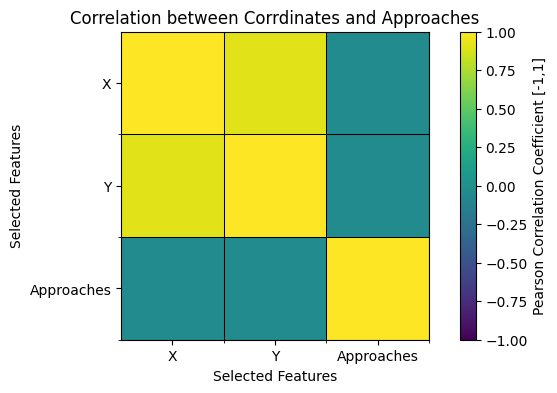

In [7]:
# Test Correlation Between Approaches and X, Y

selected = ['X', 'Y', 'Approaches']

corr_matrix = df_original[selected].corr()

plt.figure(figsize = (8,4))
plt.imshow(corr_matrix, vmin = -1, vmax = 1)
plt.colorbar(label = 'Pearson Correlation Coefficient [-1,1]')

ax = plt.gca()
ax.set_xticks(np.arange(len(corr_matrix.columns)) + 0.5, minor=True)
ax.set_yticks(np.arange(len(corr_matrix.columns)) + 0.5, minor=True)
ax.grid(which='minor', color='black', linestyle='-', linewidth=0.75)

plt.title('Correlation between Corrdinates and Approaches')
plt.xlabel('Selected Features')
plt.ylabel('Selected Features')
plt.xticks(np.arange(len(corr_matrix.columns)), corr_matrix.columns)
plt.yticks(np.arange(len(corr_matrix.columns)), corr_matrix.columns)

# Save the plot to the specified path
# desktop_path = os.path.join(os.path.expanduser("~"), "Desktop", "correlation_plot.png")
# plt.savefig(fname=desktop_path, format='png', dpi=300, bbox_inches='tight')
plt.show()

In [8]:
# Drop columns provide no predictive values
columns_to_drop = ['X', 'Y', 'Unique Squirrel ID', 'Hectare', 'Date', 
                   'Hectare Squirrel Number', 'Highlight Fur Color', 
                   'Combination of Primary and Highlight Color', 'Specific Location',
                   'Color notes', 'Lat/Long', 'Above Ground Sighter Measurement',
                  'Other Interactions','Other Activities']
df = df_original.drop(columns=columns_to_drop)
print(df.shape)
df.head()

(3023, 17)


,Shift,Age,Primary Fur Color,Location,Running,Chasing,Climbing,Eating,Foraging,Kuks,Quaas,Moans,Tail flags,Tail twitches,Approaches,Indifferent,Runs from
0,PM,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False
1,AM,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False
2,PM,NaN,Gray,Above Ground,False,True,False,False,False,False,False,False,False,False,False,False,False
3,PM,Adult,Gray,NaN,False,False,False,True,True,False,False,False,False,False,False,False,True
4,AM,Adult,Gray,Above Ground,False,False,False,False,True,False,False,False,False,False,False,False,False


In [9]:
df.describe()

,Shift,Age,Primary Fur Color,Location,Running,Chasing,Climbing,Eating,Foraging,Kuks,Quaas,Moans,Tail flags,Tail twitches,Approaches,Indifferent,Runs from
count,3023,2902,2968,2959,3023,3023,3023,3023,3023,3023,3023,3023,3023,3023,3023,3023,3023
unique,2,3,3,2,2,2,2,2,2,2,2,2,2,2,2,2,2
top,PM,Adult,Gray,Ground Plane,False,False,False,False,False,False,False,False,False,False,False,False,False
freq,1676,2568,2473,2116,2293,2744,2365,2263,1588,2921,2973,3020,2868,2589,2845,1569,2345


In [10]:
# Identify data types for each columns
print(df.dtypes)

Shift                object
Age                  object
Primary Fur Color    object
Location             object
Running                bool
Chasing                bool
Climbing               bool
Eating                 bool
Foraging               bool
Kuks                   bool
Quaas                  bool
Moans                  bool
Tail flags             bool
Tail twitches          bool
Approaches             bool
Indifferent            bool
Runs from              bool
dtype: object


#### Re-Check Missing Values after Dropping Features with No Predictive Power ####

In [11]:
# Check Missing value
print('number of corresponding missing values:')
print(df.isnull().sum())

number of corresponding missing values:
Shift                  0
Age                  121
Primary Fur Color     55
Location              64
Running                0
Chasing                0
Climbing               0
Eating                 0
Foraging               0
Kuks                   0
Quaas                  0
Moans                  0
Tail flags             0
Tail twitches          0
Approaches             0
Indifferent            0
Runs from              0
dtype: int64


In [12]:
# Check Missing valyes for Original Datasets
perc_missing_per_ftr = df.isnull().sum(axis = 0)/df.shape[0]
print('fraction of missing values in features:')
print(perc_missing_per_ftr[perc_missing_per_ftr > 0])
print('data types of the features with missing values:')
print(df[perc_missing_per_ftr[perc_missing_per_ftr > 0].index].dtypes)
frac_missing = sum(df.isnull().sum(axis = 1)!=0)/df.shape[0]
print('fraction of points with missing vlaues:', frac_missing)

fraction of missing values in features:
Age                  0.040026
Primary Fur Color    0.018194
Location             0.021171
dtype: float64
data types of the features with missing values:
Age                  object
Primary Fur Color    object
Location             object
dtype: object
fraction of points with missing vlaues: 0.06582864703936486


#### Replace nan with 'Unknown' for Categorical features ####

In [13]:
df['Age'] = df['Age'].replace('?', np.nan)
df['Age'] = df['Age'].fillna('Unknown') 
print(df['Age'].unique())

['Unknown' 'Adult' 'Juvenile']


In [14]:
df['Primary Fur Color'] = df['Primary Fur Color'].fillna('Unknown') 
print(df['Primary Fur Color'].unique())

['Unknown' 'Gray' 'Cinnamon' 'Black']


In [15]:
df['Location'] = df['Location'].fillna('Unknown') 
print(df['Location'].unique())

['Unknown' 'Above Ground' 'Ground Plane']


#### Balances of each class in the Target variable & Visualization ####

[False  True]
Approaches
False    2845
True      178
Name: count, dtype: int64


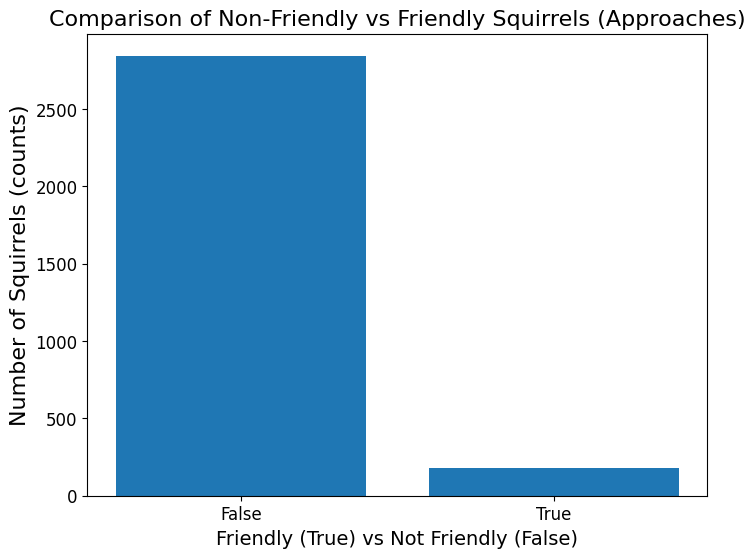

In [16]:
# Check distribution of target variable 'Approaches'
print(df['Approaches'].unique())
print(df['Approaches'].value_counts())

# A bar plot to show distribution
plt.figure(figsize = (8,6))
plt.bar(df['Approaches'].value_counts().index.astype(str), height = df_original['Approaches'].value_counts().values)
plt.title('Comparison of Non-Friendly vs Friendly Squirrels (Approaches)', fontsize=16)
plt.xlabel('Friendly (True) vs Not Friendly (False)', fontsize=14)
plt.ylabel('Number of Squirrels (counts)', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# desktop_path = os.path.join(os.path.expanduser("~"), "Desktop", "squirrel_approaches_distribution.png")
# plt.savefig(fname=desktop_path, format='png', dpi=300, bbox_inches='tight')
plt.show()

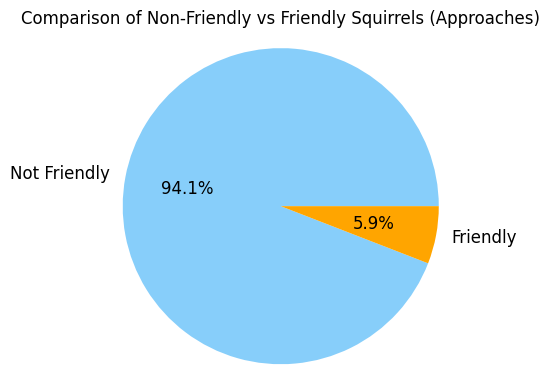

In [17]:
# Similar but Pie Plot
plt.figure(figsize=(5, 4))
plt.pie(df_original['Approaches'].value_counts(), labels=['Not Friendly', 'Friendly'], 
        autopct='%1.1f%%', textprops={'fontsize': 12}, colors = ['lightskyblue', 'orange'])
plt.title('Comparison of Non-Friendly vs Friendly Squirrels (Approaches)', fontsize=12)
plt.axis('equal')
plt.tight_layout()

# desktop_path = os.path.join(os.path.expanduser("~"), "Desktop", "squirrel_distribution_pie.png")
# plt.savefig(fname=desktop_path, format='png', dpi=300, bbox_inches='tight')
plt.show()

#### Squirrels Distribution thoughout the Park ####

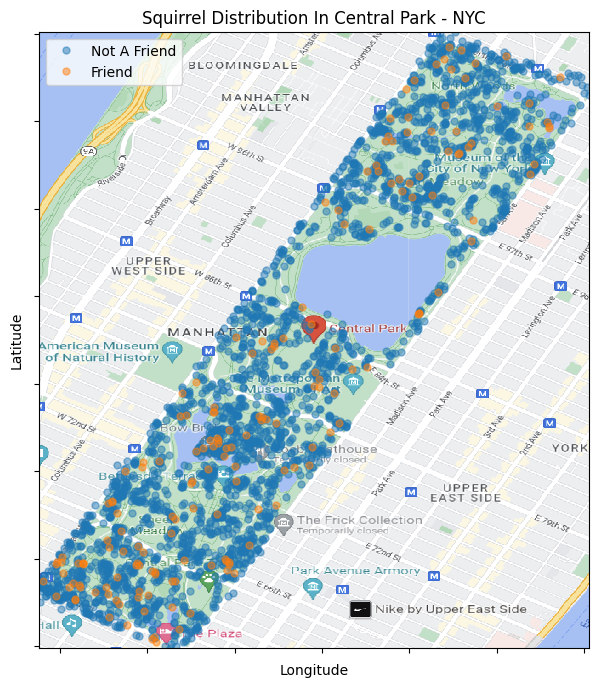

In [18]:
image_path = os.path.join(os.path.expanduser("~"), "Desktop", "1030project_squirrels", "figures", "central_park.png")

extent = (df_original['X'].min(), df_original['X'].max(), df_original['Y'].min(), df_original['Y'].max())
im = plt.imread(image_path)

plt.figure(figsize=(10, 8))
plt.imshow(im, interpolation='nearest', extent=extent)

sq_groups = df_original.groupby('Approaches')

for name, group in sq_groups:
    label = 'Friend' if name else 'Not A Friend'
    plt.plot(group['X'], group['Y'], marker='o', linestyle='', markersize=5, label=label, alpha=0.5)

plt.title('Squirrel Distribution In Central Park - NYC')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(loc='upper left')
ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])

# save_path = os.path.join(os.path.expanduser("~"), "Desktop", "squirrel_distribution_cp.png")
# plt.savefig(save_path, format='png', dpi=300, bbox_inches='tight')
plt.show()

#### More Visualizations Investigating different Features ####

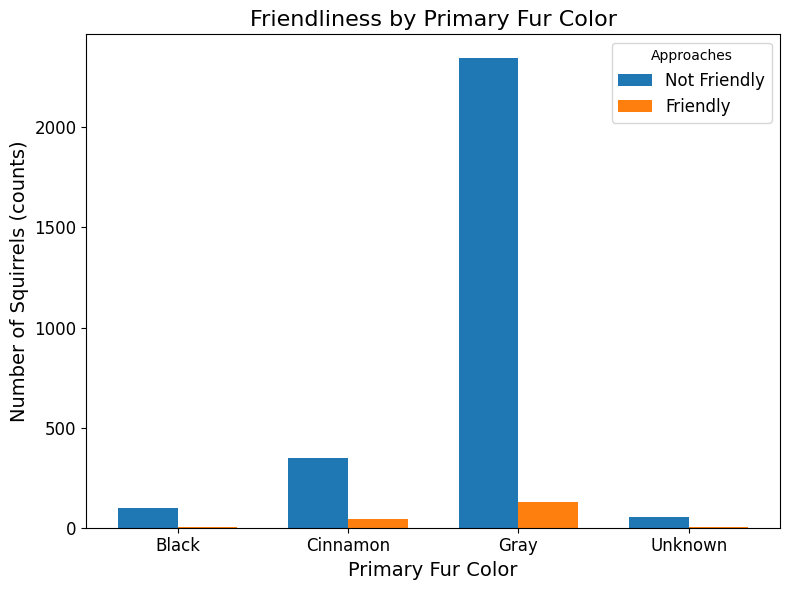

In [19]:
# Whether squirrels of different fur colors are more or less likely to approach humans
fur_counts = df.groupby('Primary Fur Color')['Approaches'].value_counts().unstack(fill_value=0)

# Create a bar plot
bar_width = 0.35
index = np.arange(len(fur_counts))
plt.figure(figsize=(8, 6))
plt.bar(index, fur_counts[False], bar_width, label='Not Friendly')
plt.bar(index + bar_width, fur_counts[True], bar_width, label='Friendly')
plt.title('Friendliness by Primary Fur Color', fontsize=16) 
plt.xlabel('Primary Fur Color', fontsize=14)  
plt.ylabel('Number of Squirrels (counts)', fontsize=14)  
plt.xticks(index + bar_width / 2, fur_counts.index, fontsize=12)
plt.yticks(fontsize=12) 
plt.legend(['Not Friendly', 'Friendly'], title="Approaches", fontsize=12)
plt.tight_layout()

# save_path = os.path.join(os.path.expanduser("~"), "Desktop", "Comparison_furcolor.png")
# plt.savefig(save_path, format='png', dpi=300, bbox_inches='tight')
plt.show()

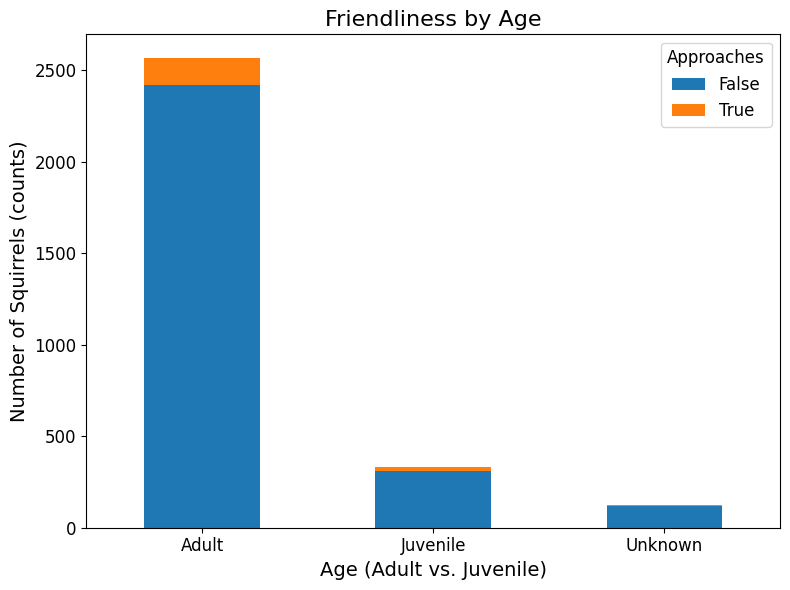

In [20]:
# Visulaize if age (adult vs. juvenile) affects how friendly squirrels are
age_counts = df.groupby('Age')['Approaches'].value_counts().unstack().dropna()

# Stacked bar plot
age_counts.plot(kind='bar', stacked=True, figsize=(8, 6))
plt.title('Friendliness by Age', fontsize=16)  
plt.xlabel('Age (Adult vs. Juvenile)', fontsize=14)  
plt.ylabel('Number of Squirrels (counts)', fontsize=14)
plt.xticks(rotation=0, fontsize=12) 
plt.yticks(fontsize=12)
plt.legend(title="Approaches", fontsize=12, title_fontsize=12)
plt.tight_layout()

# save_path = os.path.join(os.path.expanduser("~"), "Desktop", "Comparison_age.png")
# plt.savefig(save_path, format='png', dpi=300, bbox_inches='tight')
plt.show()

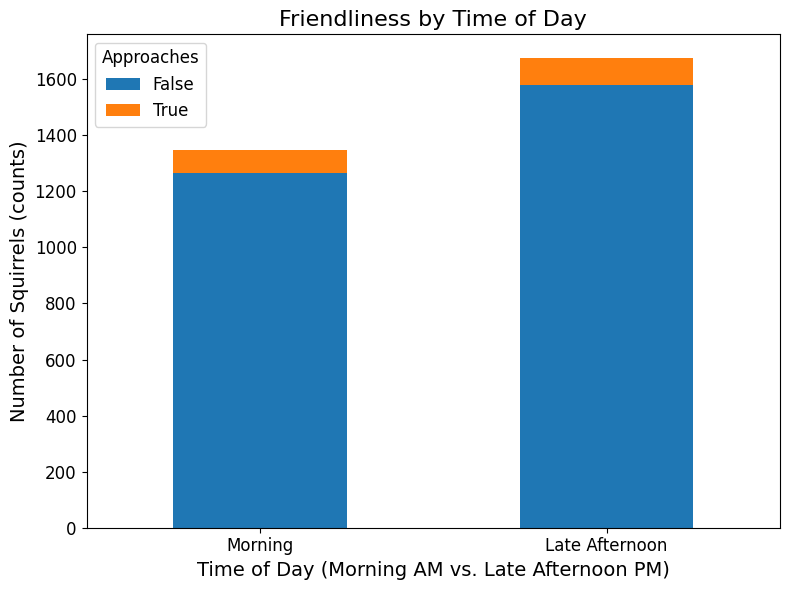

In [21]:
# if the time of day (shift: morning vs. late afternoon) influences squirrel behavior 
shift_approach = df.groupby('Shift')['Approaches'].value_counts().unstack()

# stacked bar plot
shift_approach.plot(kind='bar', stacked=True, figsize=(8, 6))
plt.title('Friendliness by Time of Day', fontsize=16)  
plt.xlabel('Time of Day (Morning AM vs. Late Afternoon PM)', fontsize=14)  
plt.ylabel('Number of Squirrels (counts)', fontsize=14)
plt.xticks([0, 1], ['Morning', 'Late Afternoon'], rotation = 0, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title="Approaches", fontsize=12, title_fontsize=12)
plt.tight_layout()

# save_path = os.path.join(os.path.expanduser("~"), "Desktop", "Comparison_time_day.png")
# plt.savefig(save_path, format='png', dpi=300, bbox_inches='tight')
plt.show()

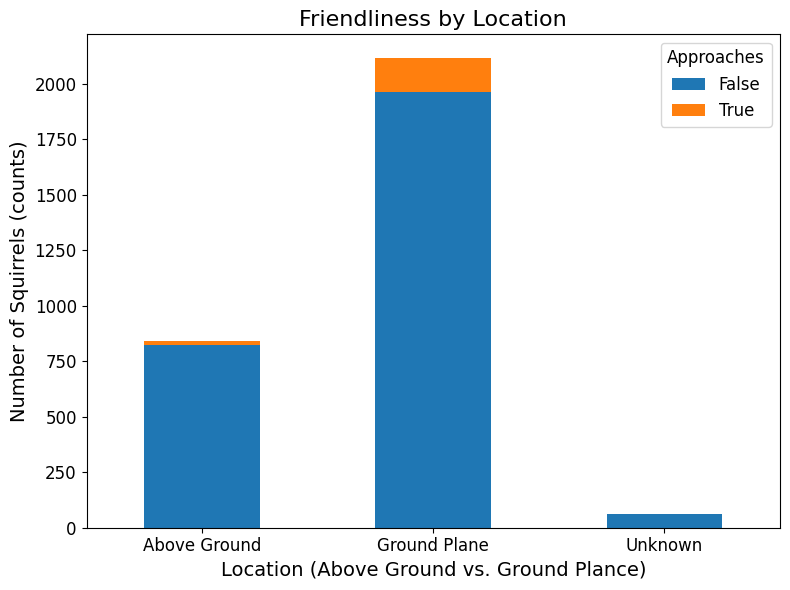

In [22]:
# if the location (above ground vs. ground plane) influences squirrel behavior 
shift_approach = df.groupby('Location')['Approaches'].value_counts().unstack()

# stacked bar plot
shift_approach.plot(kind='bar', stacked=True, figsize=(8, 6))
plt.title('Friendliness by Location', fontsize=16)  
plt.xlabel('Location (Above Ground vs. Ground Plance)', fontsize=14)  
plt.ylabel('Number of Squirrels (counts)', fontsize=14)
plt.xticks([0, 1, 2], ['Above Ground', 'Ground Plane', 'Unknown'], rotation = 0, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title="Approaches", fontsize=12, title_fontsize=12)
plt.tight_layout()

# save_path = os.path.join(os.path.expanduser("~"), "Desktop", "Comparison_location.png")
# plt.savefig(save_path, format='png', dpi=300, bbox_inches='tight')
plt.show()

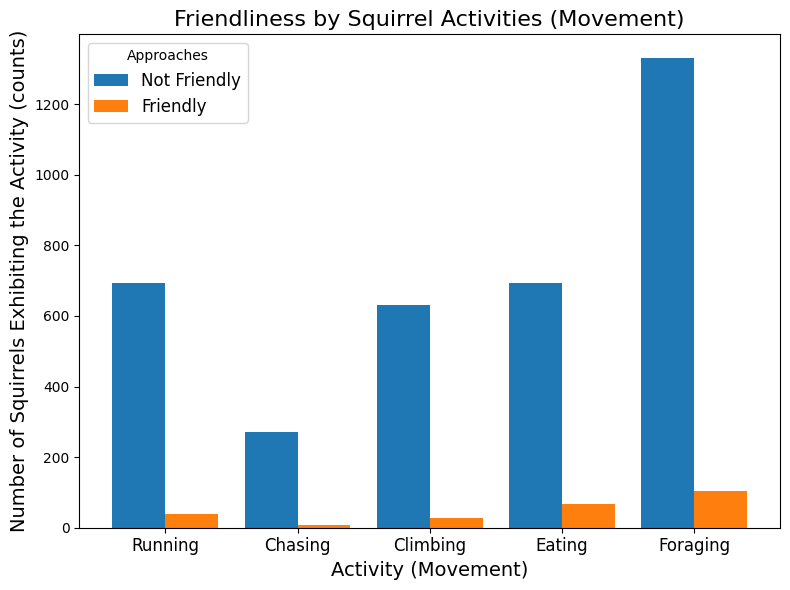

In [23]:
# Activities as a signal

# Group 1: Running, Chasing, Climbing, Eating, Foraging
activity_group_1 = ['Running', 'Chasing', 'Climbing', 'Eating', 'Foraging']
activity_approach_counts_1 = df.groupby('Approaches')[activity_group_1].sum().T

# Plot the results in a bar plot for group 1
plt.figure(figsize=(8, 6))
activity_approach_counts_1.plot(kind='bar', ax=plt.gca(), width=0.8)  # Remove stacked=True
plt.title('Friendliness by Squirrel Activities (Movement)', fontsize=16)
plt.xlabel('Activity (Movement)', fontsize=14)
plt.ylabel('Number of Squirrels Exhibiting the Activity (counts)', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.legend(['Not Friendly', 'Friendly'], title="Approaches", fontsize=12)
plt.tight_layout()

# save_path = os.path.join(os.path.expanduser("~"), "Desktop", "Comparison_movement_activities.png")
# plt.savefig(save_path, format='png', dpi=300, bbox_inches='tight')
plt.show()

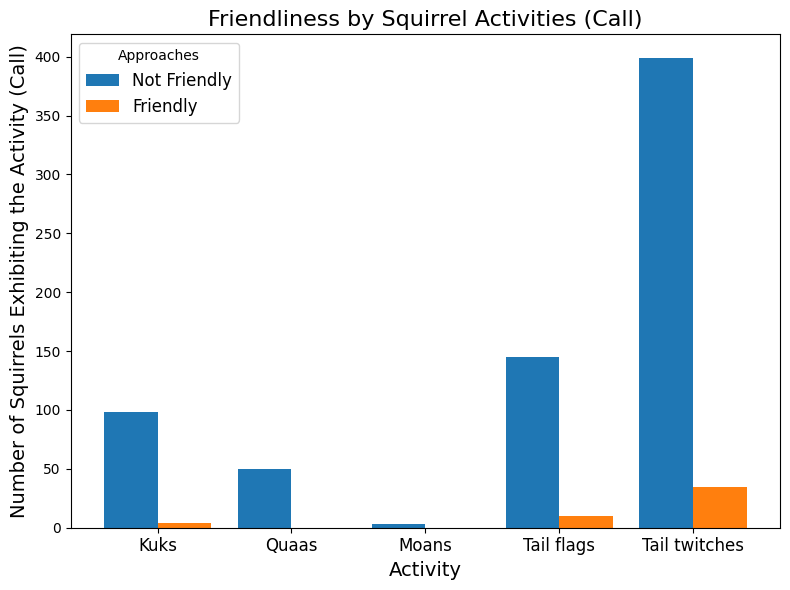

In [24]:
# Group 2: Kuks, Quaas, Moans, Tail flags, Tail twitches
activity_group_2 = ['Kuks', 'Quaas', 'Moans', 'Tail flags', 'Tail twitches']
activity_approach_counts_2 = df.groupby('Approaches')[activity_group_2].sum().T

# Plot the results in a stacked bar plot for group 2
plt.figure(figsize=(8, 6))
activity_approach_counts_2.plot(kind='bar', ax=plt.gca(), width = 0.8)
plt.title('Friendliness by Squirrel Activities (Call)', fontsize=16)
plt.xlabel('Activity', fontsize=14)
plt.ylabel('Number of Squirrels Exhibiting the Activity (Call)', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.legend(['Not Friendly', 'Friendly'], title="Approaches", fontsize=12)
plt.tight_layout()

# save_path = os.path.join(os.path.expanduser("~"), "Desktop", "Comparison_call_activities.png")
# plt.savefig(save_path, format='png', dpi=300, bbox_inches='tight')
plt.show()

# Models #

In [25]:
y = df['Approaches'] # targeted variable
X = df.loc[:, df.columns != 'Approaches'] # feature matrix

In [26]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import ParameterGrid

from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import xgboost

from sklearn.metrics import precision_score   # here I chose precision as evaluation metrics to minimize False Positive
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#### Store Preprocessing Encoders in Preprocessor ####

In [27]:
print(df.dtypes)

Shift                object
Age                  object
Primary Fur Color    object
Location             object
Running                bool
Chasing                bool
Climbing               bool
Eating                 bool
Foraging               bool
Kuks                   bool
Quaas                  bool
Moans                  bool
Tail flags             bool
Tail twitches          bool
Approaches             bool
Indifferent            bool
Runs from              bool
dtype: object


In [28]:
# Define different-types features
categorical_ftrs = ['Shift', 'Age', 'Primary Fur Color', 'Location']
boolean_ftrs = ['Running', 'Chasing', 'Climbing', 'Eating', 'Foraging', 
                'Kuks', 'Quaas', 'Moans', 'Tail flags', 'Tail twitches', 
                'Indifferent', 'Runs from']

# Apply preprocessing and Combine all transformers
preprocessor = ColumnTransformer(
    transformers = [
        ('onehot', OneHotEncoder(sparse_output = False, handle_unknown = 'ignore'), categorical_ftrs),
        ('boolean', StandardScaler(), boolean_ftrs)])

## Logistic Regression ##

In [29]:
param_grid = {
    'logisticregression__C': [0.01, 0.1, 1, 10],
    'logisticregression__penalty': ['elasticnet'],
    'logisticregression__l1_ratio': [0, 0.25, 0.5, 0.75, 1]}  # so that 0 indicates L2, 1 indicated L1

nr_states = 5
lr_test_scores = []
lr_final_models = []

# Hyperparameter tuning with folds
for i in range(nr_states):
    # First split to separate out the test set
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 42*i)
    # splitter for other
    kf = StratifiedKFold(n_splits = 4, shuffle = True, random_state = 42*i) # Imbalanced, stratify

    # logistic regression
    lr = LogisticRegression(solver = 'saga', max_iter = 220000, random_state = 42*i, class_weight = 'balanced')

    pipe = make_pipeline(preprocessor, lr)

    # GridSearchCV
    grid = GridSearchCV(pipe, param_grid = param_grid, scoring = 'precision', cv = kf, return_train_score = True, n_jobs = -1)

    # Fit the model on other and loops through the 4 different validation sets
    grid.fit(X_other, y_other)

    # Compare number of features before and after preprocessed
    if i == 0:  # Only print once
        best_pipe = grid.best_estimator_
        X_other_prep = best_pipe.named_steps['columntransformer'].transform(X_other)

        # Save preprocessed data
        # preprocessed_df = pd.DataFrame(
        #     X_other_prep, 
        #     columns = best_pipe.named_steps['columntransformer'].get_feature_names_out())
        # preprocessed_df['target'] = y_other.reset_index(drop = True)
        # desktop_path = os.path.join(os.path.expanduser("~"), "Desktop")
        # csv_path = os.path.join(desktop_path, "preprocessed_data.csv")
        # preprocessed_df.to_csv(csv_path, index = False)
        
        print(f'Number of features before preprocessed: {X_other.shape[1]}')
        print(f'Number of features after preprocessing: {X_other_prep.shape[1]}')

    # Save results into a data frame
    results_lr = pd.DataFrame(grid.cv_results_)
    # print(results_lr)

    print('\nBest model parameters:', grid.best_params_)
    print('validation score:', grid.best_score_)
    # save the model 
    lr_final_models.append(grid)

    # calculate and save the test score
    y_test_pred = lr_final_models[-1].predict(X_test)
    test_score = precision_score(y_test, y_test_pred)
    lr_test_scores.append(test_score)
    print('test score:', test_score)

Number of features before preprocessed: 16
Number of features after preprocessing: 24

Best model parameters: {'logisticregression__C': 0.1, 'logisticregression__l1_ratio': 1, 'logisticregression__penalty': 'elasticnet'}
validation score: 0.17610290506760398
test score: 0.15168539325842698

Best model parameters: {'logisticregression__C': 0.1, 'logisticregression__l1_ratio': 1, 'logisticregression__penalty': 'elasticnet'}
validation score: 0.15802967355330585
test score: 0.1935483870967742

Best model parameters: {'logisticregression__C': 0.1, 'logisticregression__l1_ratio': 1, 'logisticregression__penalty': 'elasticnet'}
validation score: 0.17258943554201822
test score: 0.18831168831168832

Best model parameters: {'logisticregression__C': 0.1, 'logisticregression__l1_ratio': 0.75, 'logisticregression__penalty': 'elasticnet'}
validation score: 0.16573230693781807
test score: 0.15789473684210525

Best model parameters: {'logisticregression__C': 10, 'logisticregression__l1_ratio': 0, 'lo

In [30]:
print(f'Test Precision Mean: {np.mean(lr_test_scores)}')
print(f'Test Precision std: {np.std(lr_test_scores)}')

Test Precision Mean: 0.17183642819857314
Test Precision std: 0.016492684394122915


<Figure size 600x600 with 0 Axes>

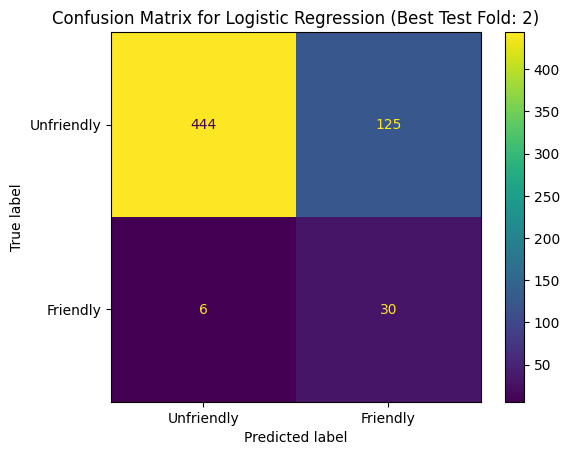

In [31]:
# Draw confusion matrix to check if our model did not always predict majority class
best_fold_index = max(range(len(lr_test_scores)), key=lambda i: lr_test_scores[i])
best_model = lr_final_models[best_fold_index].best_estimator_

X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42 * best_fold_index)

y_test_pred = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_test_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Unfriendly", "Friendly"])
plt.figure(figsize=(6, 6))
disp.plot(values_format='d')
plt.title(f"Confusion Matrix for Logistic Regression (Best Test Fold: {best_fold_index + 1})")
plt.show()

## Random Forest ##

In [32]:
param_grid = {
    'randomforestclassifier__max_depth': [1, 3, 10, 30],
    'randomforestclassifier__max_features': [0.01, 0.1, 0.5, 1]}
nr_states = 5
rf_test_scores = []
rf_final_models = []
rf_test_sets = []  

for i in range(nr_states):
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 42*i)
    kf = StratifiedKFold(n_splits = 4, shuffle = True, random_state = 42*i)
    rf_test_sets.append((X_test, y_test))  # Save the test set for later use

    rf = RandomForestClassifier(random_state = 42*i, class_weight = 'balanced')

    pipe = make_pipeline(preprocessor, rf)

    grid = GridSearchCV(pipe, param_grid = param_grid, scoring = 'precision', cv = kf, return_train_score = True, n_jobs = -1)

    grid.fit(X_other, y_other)

    results_rf = pd.DataFrame(grid.cv_results_)
    # print(results_rf)

    print('\nBest model parameters:', grid.best_params_)
    print('validation score:', grid.best_score_)

    rf_final_models.append(grid)

    y_test_pred = rf_final_models[-1].predict(X_test)
    test_score = precision_score(y_test, y_test_pred)
    rf_test_scores.append(test_score)
    print('test score:', test_score)


Best model parameters: {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__max_features': 0.01}
validation score: 0.2233210946618764
test score: 0.18888888888888888

Best model parameters: {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__max_features': 0.01}
validation score: 0.21833958724202626
test score: 0.24675324675324675

Best model parameters: {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__max_features': 0.1}
validation score: 0.21113636866441007
test score: 0.2727272727272727

Best model parameters: {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__max_features': 0.5}
validation score: 0.22539708383081875
test score: 0.20869565217391303

Best model parameters: {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__max_features': 0.01}
validation score: 0.2279173118941049
test score: 0.21839080459770116


In [33]:
print(f'Test Precision Mean: {np.mean(rf_test_scores)}')
print(f'Test Precision std: {np.std(rf_test_scores)}')

Test Precision Mean: 0.2270911730282045
Test Precision std: 0.029471195600791176


<Figure size 600x600 with 0 Axes>

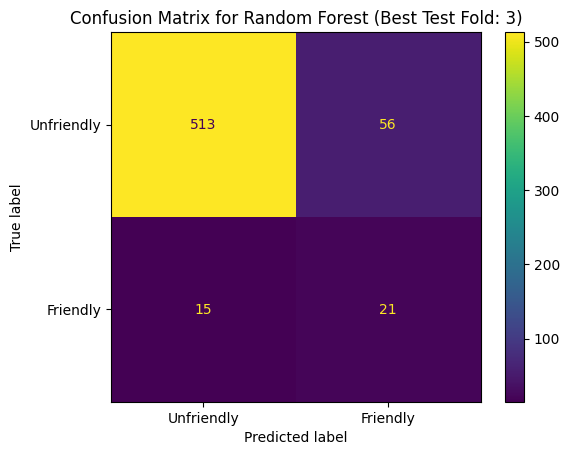

In [34]:
# Draw confusion matrix to check if our model did not always predict majority class
best_fold_index = max(range(len(rf_test_scores)), key=lambda i: rf_test_scores[i])
best_model = rf_final_models[best_fold_index].best_estimator_

X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42 * best_fold_index)

y_test_pred = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_test_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Unfriendly", "Friendly"])
plt.figure(figsize=(6, 6))
disp.plot(values_format='d')
plt.title(f"Confusion Matrix for Random Forest (Best Test Fold: {best_fold_index + 1})")
plt.show()

## SVC ##

In [35]:
param_grid = {
    'svc__gamma': [0.1, 1, 10, 100],
    'svc__C': [0.01, 0.1, 1]}
nr_states = 5
svc_test_scores = []
svc_final_models = []

for i in range(nr_states):
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 42*i)
    kf = StratifiedKFold(n_splits = 4, shuffle = True, random_state = 42*i)

    svc = SVC(probability = True, random_state = 42*i, class_weight = 'balanced')

    pipe = make_pipeline(preprocessor, svc)

    grid = GridSearchCV(pipe, param_grid = param_grid, scoring = 'precision', cv = kf, return_train_score = True, n_jobs = -1)

    grid.fit(X_other, y_other)

    results_svc = pd.DataFrame(grid.cv_results_)
    # print(results_svc)

    print('\nBest model parameters:', grid.best_params_)
    print('validation score:', grid.best_score_)

    svc_final_models.append(grid)

    y_test_pred = svc_final_models[-1].predict(X_test)

    # Suppress the warning at the point of precision calculation
    test_score = precision_score(y_test, y_test_pred)
    svc_test_scores.append(test_score)
    print('test score:', test_score)


Best model parameters: {'svc__C': 0.1, 'svc__gamma': 0.1}
validation score: 0.1845438314913569
test score: 0.16666666666666666

Best model parameters: {'svc__C': 0.1, 'svc__gamma': 1}
validation score: 0.18262010176723165
test score: 0.2236842105263158

Best model parameters: {'svc__C': 1, 'svc__gamma': 0.1}
validation score: 0.17654444295716132
test score: 0.1953125

Best model parameters: {'svc__C': 0.1, 'svc__gamma': 1}
validation score: 0.21807976021626047
test score: 0.18095238095238095

Best model parameters: {'svc__C': 0.1, 'svc__gamma': 10}
validation score: 0.21742217548584672
test score: 0.18840579710144928


In [36]:
print(f'Test Precision Mean: {np.mean(svc_test_scores)}')
print(f'Test Precision std: {np.std(svc_test_scores)}')

Test Precision Mean: 0.19100431104936252
Test Precision std: 0.018903178724060336


<Figure size 600x600 with 0 Axes>

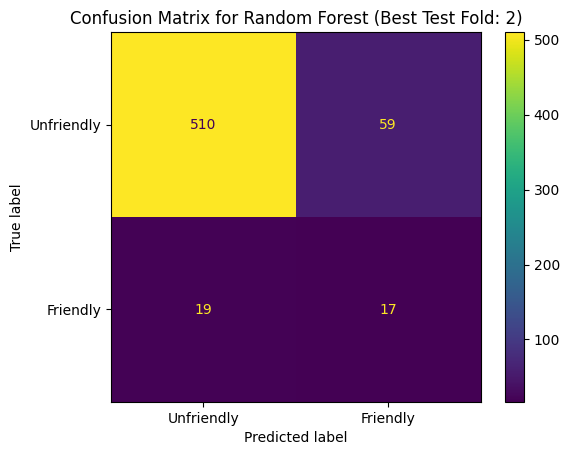

In [37]:
# Draw confusion matrix to check if our model did not always predict majority class
best_fold_index = max(range(len(svc_test_scores)), key=lambda i: svc_test_scores[i])
best_model = svc_final_models[best_fold_index].best_estimator_

X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42 * best_fold_index)

y_test_pred = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_test_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Unfriendly", "Friendly"])
plt.figure(figsize=(6, 6))
disp.plot(values_format='d')
plt.title(f"Confusion Matrix for Random Forest (Best Test Fold: {best_fold_index + 1})")
plt.show()

## KNN ##

In [38]:
param_grid = {
    'kneighborsclassifier__n_neighbors': [1, 3, 10, 30]}
nr_states = 5
knn_test_scores = []
knn_final_models = []

for i in range(nr_states):
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 42*i)
    kf = StratifiedKFold(n_splits = 4, shuffle = True, random_state = 42*i)

    knn = KNeighborsClassifier(weights = 'distance')

    pipe = make_pipeline(preprocessor, knn)

    grid = GridSearchCV(pipe, param_grid = param_grid, scoring = 'precision', cv = kf, return_train_score = True, n_jobs = -1)

    grid.fit(X_other, y_other)

    results_knn = pd.DataFrame(grid.cv_results_)
    # print(results_knn)

    print('\nBest model parameters:', grid.best_params_)
    print('validation score:', grid.best_score_)

    knn_final_models.append(grid)

    y_test_pred = knn_final_models[-1].predict(X_test)
    test_score = precision_score(y_test, y_test_pred)
    knn_test_scores.append(test_score)
    print('test score:', test_score)


Best model parameters: {'kneighborsclassifier__n_neighbors': 3}
validation score: 0.2741396761133603
test score: 0.15

Best model parameters: {'kneighborsclassifier__n_neighbors': 3}
validation score: 0.21599264705882354
test score: 0.3333333333333333

Best model parameters: {'kneighborsclassifier__n_neighbors': 1}
validation score: 0.1285189075630252
test score: 0.19444444444444445

Best model parameters: {'kneighborsclassifier__n_neighbors': 1}
validation score: 0.3093825532849923
test score: 0.16666666666666666

Best model parameters: {'kneighborsclassifier__n_neighbors': 1}
validation score: 0.23777972027972027
test score: 0.14285714285714285


In [39]:
print(f'Test Precision Mean: {np.mean(knn_test_scores)}')
print(f'Test Precision std: {np.std(knn_test_scores)}')

Test Precision Mean: 0.19746031746031742
Test Precision std: 0.07021795962836984


<Figure size 600x600 with 0 Axes>

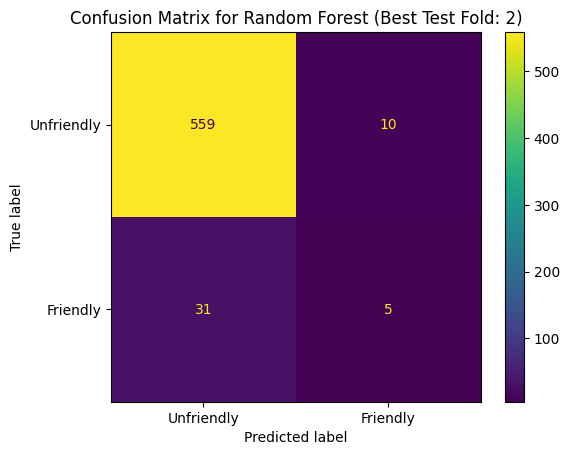

In [40]:
# Draw confusion matrix to check if our model did not always predict majority class
best_fold_index = max(range(len(knn_test_scores)), key=lambda i: knn_test_scores[i])
best_model = knn_final_models[best_fold_index].best_estimator_

X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42 * best_fold_index)

y_test_pred = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_test_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Unfriendly", "Friendly"])
plt.figure(figsize=(6, 6))
disp.plot(values_format='d')
plt.title(f"Confusion Matrix for Random Forest (Best Test Fold: {best_fold_index + 1})")
plt.show()

## XGBoost ##

In [41]:
pos_count = np.sum(y == 1)  # Number of positive samples
neg_count = np.sum(y == 0)  # Number of negative samples
scale_pos_weight = neg_count / pos_count

param_grid = {
    'learning_rate': [0.03],
    'n_estimators': [10000],
    'seed': [0],
    'reg_alpha': [0e0, 1e-2, 1e-1, 1e1, 1e2],
    #'reg_lambda': [0e0, 1e-2, 1e-1, 1e0, 1e1, 1e2],
    #'missing': [np.nan]
    'max_depth': [1, 3, 10, 30, 100],
    'colsample_bytree': [0.1], #0.9
    'subsample': [0.33]} #0.66

nr_states = 5
xgb_test_scores = []
xgb_final_models = []

for i in range(nr_states):
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42 * i)

    kf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42 * i)

    best_model = None
    best_val_score = -np.inf
    best_params = None

    for train_idx, val_idx in kf.split(X_other, y_other):
        X_train, X_val = X_other.iloc[train_idx], X_other.iloc[val_idx]
        y_train, y_val = y_other.iloc[train_idx], y_other.iloc[val_idx]

        X_train_prep = preprocessor.fit_transform(X_train)
        X_val_prep = preprocessor.transform(X_val)
        X_test_prep = preprocessor.transform(X_test)

        for params in ParameterGrid(param_grid):
            xgb = xgboost.XGBClassifier(eval_metric='logloss', random_state=42 * i, scale_pos_weight=scale_pos_weight, n_jobs=-1)
            xgb.set_params(**params, early_stopping_rounds=100) # with early stopping rounds 

            xgb.fit(
                X_train_prep,
                y_train,
                eval_set=[(X_val_prep, y_val)],
                verbose=False
            )

            y_val_pred = xgb.predict(X_val_prep)
            val_score = precision_score(y_val, y_val_pred)

            if val_score > best_val_score:
                best_val_score = val_score
                best_model = xgb
                best_params = params

    y_test_pred = best_model.predict(X_test_prep)
    test_score = precision_score(y_test, y_test_pred)
    xgb_test_scores.append(test_score)
    xgb_final_models.append(best_model)

    print("\nBest Parameters:", best_params)
    print("Best Validation Precision:", best_val_score)
    print("Test Precision:", test_score)


Best Parameters: {'colsample_bytree': 0.1, 'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 10000, 'reg_alpha': 0.0, 'seed': 0, 'subsample': 0.33}
Best Validation Precision: 0.1953125
Test Precision: 0.17763157894736842

Best Parameters: {'colsample_bytree': 0.1, 'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 10000, 'reg_alpha': 10.0, 'seed': 0, 'subsample': 0.33}
Best Validation Precision: 0.18115942028985507
Test Precision: 0.09686609686609686

Best Parameters: {'colsample_bytree': 0.1, 'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 10000, 'reg_alpha': 0.0, 'seed': 0, 'subsample': 0.33}
Best Validation Precision: 0.19858156028368795
Test Precision: 0.23931623931623933

Best Parameters: {'colsample_bytree': 0.1, 'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 10000, 'reg_alpha': 0.0, 'seed': 0, 'subsample': 0.33}
Best Validation Precision: 0.21052631578947367
Test Precision: 0.09779179810725552

Best Parameters: {'colsample_bytree': 0.1, 'learning_rate': 

In [42]:
print(f'Test Precision Mean: {np.mean(xgb_test_scores)}')
print(f'Test Precision std: {np.std(xgb_test_scores)}')

Test Precision Mean: 0.16442640580528675
Test Precision std: 0.058159490624643526


<Figure size 600x600 with 0 Axes>

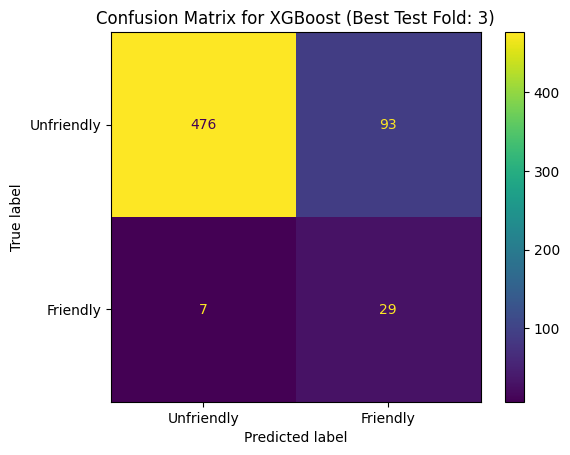

In [43]:
# Draw confusion matrix to check if our model did not always predict majority class
best_fold_index = max(range(len(xgb_test_scores)), key=lambda i: xgb_test_scores[i])

best_model = xgb_final_models[best_fold_index]

X_other, X_test, y_other, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42 * best_fold_index
)

X_test_prep = preprocessor.transform(X_test)

y_test_pred = best_model.predict(X_test_prep)

cm = confusion_matrix(y_test, y_test_pred, labels=[0, 1])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Unfriendly", "Friendly"])
plt.figure(figsize=(6, 6))
disp.plot(values_format='d')
plt.title(f"Confusion Matrix for XGBoost (Best Test Fold: {best_fold_index + 1})")
plt.show()

# Model Test Score Difference #

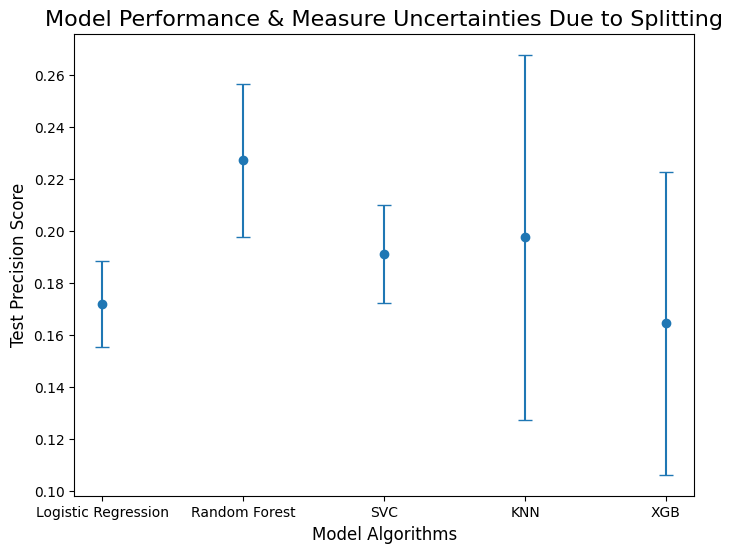

In [44]:
# Comparison based on precision
acc_means = [np.mean(lr_test_scores), np.mean(rf_test_scores), np.mean(svc_test_scores), np.mean(knn_test_scores), np.mean(xgb_test_scores)]
acc_stds = [np.std(lr_test_scores), np.std(rf_test_scores), np.std(svc_test_scores), np.std(knn_test_scores), np.std(xgb_test_scores)]
plt.figure(figsize = (8, 6))
plt.errorbar(['Logistic Regression', 'Random Forest', 'SVC', 'KNN', 'XGB'], acc_means, yerr = acc_stds, capsize = 5, fmt = 'o')
plt.title('Model Performance & Measure Uncertainties Due to Splitting', fontsize=16)
plt.xlabel('Model Algorithms', fontsize=12)
plt.ylabel('Test Precision Score', fontsize=12)
plt.show()

#### Based on the plot, Random Forest is the best model ####

In [45]:
# Store the best Random Forest Model
import pickle

best_index = rf_test_scores.index(max(rf_test_scores))
best_model = rf_final_models[best_index].best_estimator_  

# desktop_path = os.path.join(os.path.expanduser("~"), "Desktop")
# model_path = os.path.join(desktop_path, "best_rf_model.pkl")
# with open(model_path, 'wb') as model_file:
#     pickle.dump(best_model, model_file)
# print(f"Best Random Forest model saved to {model_path}")

In [46]:
# Store prediction using best model
X_test_prep = best_model.named_steps['columntransformer'].transform(X_test)

y_pred = best_model.named_steps['randomforestclassifier'].predict(X_test_prep)

prediction_df = pd.DataFrame({'predictions': y_pred})
# prediction_path = os.path.join(desktop_path, "rf_predictions.csv")
# prediction_df.to_csv(prediction_path, index=False)
# print(f"Predictions saved to {prediction_path}")

In [47]:
df_test = best_model[0].transform(rf_test_sets[best_index][0])
df_test = pd.DataFrame(data = df_test, columns = best_model[0].get_feature_names_out())
df_test.head()

,onehot__Shift_AM,onehot__Shift_PM,onehot__Age_Adult,onehot__Age_Juvenile,onehot__Age_Unknown,onehot__Primary Fur Color_Black,onehot__Primary Fur Color_Cinnamon,onehot__Primary Fur Color_Gray,onehot__Primary Fur Color_Unknown,onehot__Location_Above Ground,...,boolean__Climbing,boolean__Eating,boolean__Foraging,boolean__Kuks,boolean__Quaas,boolean__Moans,boolean__Tail flags,boolean__Tail twitches,boolean__Indifferent,boolean__Runs from
0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.537506,-0.585947,1.045709,-0.187357,-0.129695,-0.028772,-0.231505,-0.405882,1.044842,-0.534949
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.537506,-0.585947,-0.956289,-0.187357,-0.129695,-0.028772,-0.231505,2.463773,-0.957082,1.869338
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.537506,-0.585947,1.045709,-0.187357,-0.129695,-0.028772,-0.231505,-0.405882,1.044842,-0.534949
3,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.537506,-0.585947,-0.956289,-0.187357,-0.129695,-0.028772,-0.231505,-0.405882,-0.957082,-0.534949
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.860445,-0.585947,-0.956289,-0.187357,-0.129695,-0.028772,-0.231505,-0.405882,-0.957082,-0.534949


## Global Feature Importance - Permutation Importance ##

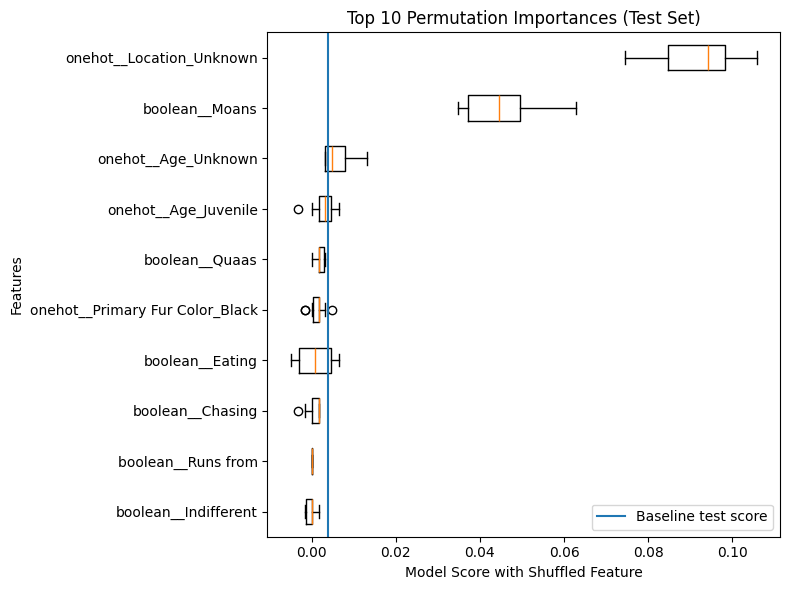

In [80]:
from sklearn.inspection import permutation_importance

feature_names = preprocessor.get_feature_names_out()
result = permutation_importance(best_model.named_steps['randomforestclassifier'], df_test, rf_test_sets[best_index][1], n_repeats = 10, random_state = 0)

importances = result.importances
sorted_indices = np.argsort(importances.mean(axis=1))[::-1][:10] 
reverse_indices = sorted_indices[::-1]

plt.figure(figsize=(8, 6))
plt.boxplot(importances[reverse_indices].T, vert=False, labels=np.array(feature_names)[sorted_indices[:10]])
plt.axvline(result.importances_mean.mean(), label='Baseline test score')
plt.title("Top 10 Permutation Importances (Test Set)")
plt.xlabel("Model Score with Shuffled Feature")
plt.ylabel("Features")
plt.legend()
plt.tight_layout()
plt.show()

## Global Feature Importance - Coefficient ##

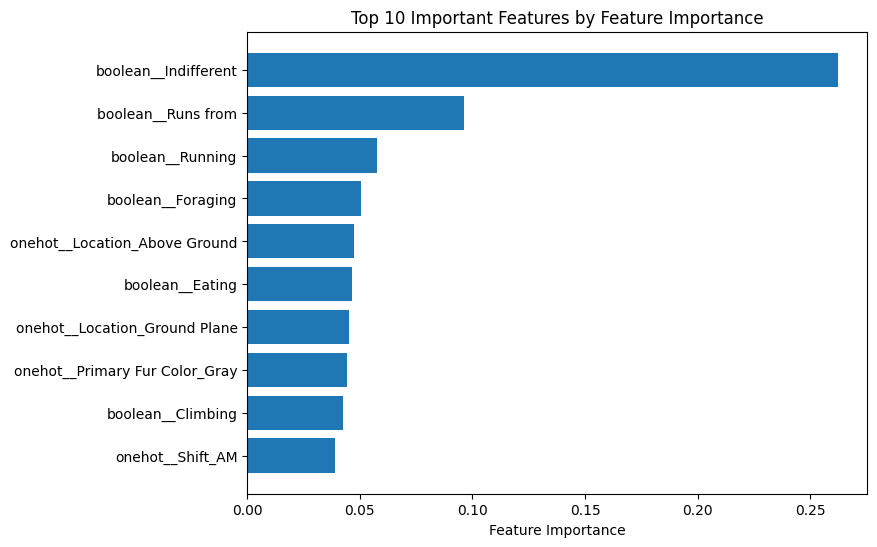

In [81]:
importances = best_model[-1].feature_importances_
sorted_indices = np.argsort(importances)

top_indices = sorted_indices[-10:]

plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 10})
plt.barh(np.arange(10), importances[top_indices])
plt.yticks(np.arange(10), np.array(df_test.columns)[top_indices])
plt.xlabel('Feature Importance')
plt.title('Top 10 Important Features by Feature Importance')
plt.show()

## Global Feature Importance - Shap Value ##

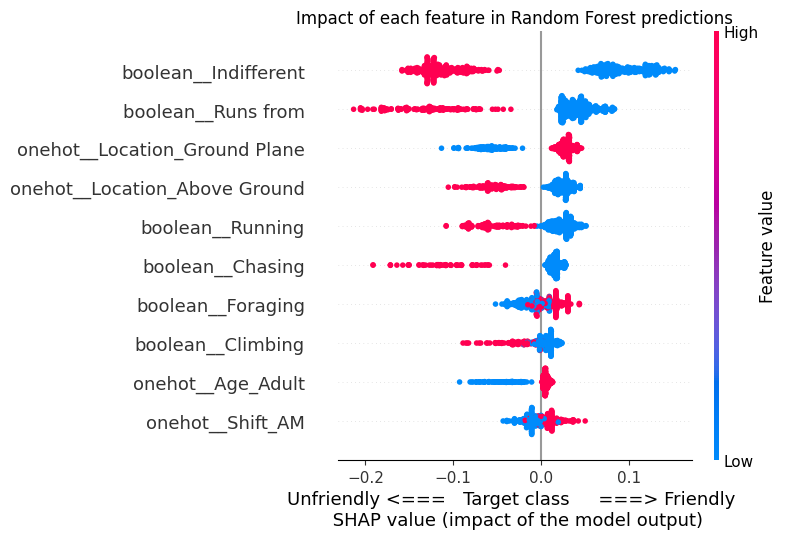

In [108]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(best_model.named_steps['randomforestclassifier'], df_test)

shap_values = explainer.shap_values(df_test)

shap.summary_plot(shap_values[:,:,1], df_test, feature_names = feature_names, max_display=10, show = False)  
fig = plt.gcf()
ax = plt.gca()
ax.set_xlabel("Unfriendly <===   Target class     ===> Friendly \n SHAP value (impact of the model output)")
ax.set_title("Impact of each feature in Random Forest predictions")
plt.tight_layout()
plt.show()

## Local Feature Importance: SHAP Values ##

In [144]:
print(explainer.expected_value[1])

0.2773726167431369


In [380]:
# Model strongly predict friendly class
shap.initjs()
index = 120
shap.force_plot(explainer.expected_value[1], shap_values[index, :, 1], features = df_test.iloc[index, :], feature_names = feature_names)

In [392]:
# Model predicts unfriendly class with high confidence
shap.initjs()
index = 540
shap.force_plot(explainer.expected_value[1], shap_values[index, :, 1], features = df_test.iloc[index, :], feature_names = feature_names)